# Dependencies

Download pre-trained CDDD autoencoder model and molecule test sets:

In [1]:
import os
os.mkdir('models')
!gdown 1oyknOulq_j0w9kzOKKIHdTLo5HphT99h
!unzip default_model.zip 
os.rename('default_model','models/default_model')
!gdown 1g31LlI7Gdi1-6cQ5qiyDFIKB3LqFAgCq
!unzip cddd.zip

!gdown 188RxoPWpm7a1fs3Y3f-Fq75LattR0_Ab
!unzip data.zip

Downloading...
From: https://drive.google.com/uc?id=1oyknOulq_j0w9kzOKKIHdTLo5HphT99h
To: /content/default_model.zip
100% 586M/586M [00:03<00:00, 183MB/s]
Archive:  default_model.zip
   creating: default_model/
  inflating: default_model/checkpoint  
  inflating: default_model/eval_qsar.csv  
  inflating: default_model/eval_reconstruct.csv  
  inflating: default_model/hparams.json  
  inflating: default_model/model.ckpt.data-00000-of-00001  
  inflating: default_model/model.ckpt.index  
  inflating: default_model/model.ckpt.meta  
 extracting: default_model/__init__.py  
Downloading...
From: https://drive.google.com/uc?id=1g31LlI7Gdi1-6cQ5qiyDFIKB3LqFAgCq
To: /content/cddd.zip
100% 53.1k/53.1k [00:00<00:00, 65.5MB/s]
Archive:  cddd.zip
  inflating: cddd/__init__.py        
  inflating: cddd/models.py          
  inflating: cddd/__pycache__/models.cpython-37.pyc  
  inflating: cddd/model_helper.py    
  inflating: cddd/train.py           
  inflating: cddd/input_pipeline.py  
  inflatin

Install other dependencies:

In [2]:
!pip install numpy==1.19.5
!pip install scikit-learn==0.21.3
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c rdkit rdkit
# kernel should automatically restart after running this cell
# so let this cell finish running first before running the others

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.8 MB 7.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jax 0.3.17 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
cmdstanpy 1.0.7 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.21.3 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.3 which is incompatible.
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...
Solving environment: / - \ | / - \ | / -

In [1]:
import numpy as np
print(np.__version__) # should be 1.19.5
import sklearn
print(sklearn.__version__) # should be 0.21.3
!pip install tensorflow_gpu==1.15.2
!pip install molsets
!pip install moses
!pip install tensorboardX
!pip install PyTDC

1.19.5
1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# QMO source code
Modified from https://github.com/IBM/QMO

## models.py

In [2]:
from abc import ABC, abstractmethod
import os.path as osp

from cddd.inference import InferenceModel
import numpy as np
from rdkit import Chem
import torch

class Model(ABC):
    """Basic encoder-decoder model abstract base class.

    Attributes:
        decode_failure_count (float): Running tally of invalid decoded strings.
        total_decoding (float): Running tally of total decodes.
    """
    def __init__(self):
        self.decode_failure_count = 0
        self.total_decoding = 0

    @abstractmethod
    def decode(self, z):
        """Decode latent vectors.

        Args:
            z (torch.Tensor): Batch of latent vectors.

        Returns:
            tuple:
                * **mols** (`list`) -- List of `:class:~rdkit.Chem.rdchem.Mol`.
                * ** samples** (`list`) -- List of SMILES strings.
        """
        raise NotImplementedError

    @abstractmethod
    def encode(self, seq):
        """Encode sequences.

        Args:
            seq (list): List of (string) sequences.

        Returns:
            torch.Tensor: Latent representation.
        """
        raise NotImplementedError

class CDDDModel(Model):
    def __init__(self, model_dir='models/default_model', eps_clip=1e-7): # 
        """Load CDDD model.

        Args:
            model_dir (str): Path to model (e.g. ``.../default_model``).
        """
        super().__init__()
        # make path relative to this file if not already absolute
        # if not osp.isabs(model_dir):
            # model_dir = osp.join(osp.dirname(osp.abspath(__file__)), model_dir)
        self.model = InferenceModel(model_dir=model_dir, num_top=2)
        self.eps_clip = eps_clip

    def decode(self, z):
        z = torch.clamp(z, -1, 1)
        num_embs = 1 if z.ndim == 1 else z.shape[0]
        self.total_decoding += num_embs
        samples = self.model.emb_to_seq(z.numpy())  # [n x 2]
        if isinstance(samples[0], str):
            samples = [samples]
        mols, samples1 = [], []
        for s0, s1 in samples:
            mol0 = Chem.MolFromSmiles(s0)
            if mol0 is not None:
                mols.append(mol0)
                samples1.append(s0)
                continue
            mol1 = Chem.MolFromSmiles(s1)
            if mol1 is not None:
                mols.append(mol1)
                samples1.append(s1)
            else:
                self.decode_failure_count += 1
                mols.append(None)
                samples1.append(s0)
        return mols, samples1

    def encode(self, seq):
        orig_emb = self.model.seq_to_emb(seq)
        z_0 = torch.tensor(orig_emb).detach().cpu()
        return z_0

## losses.py

In [3]:
from functools import lru_cache

import numpy as np
import pandas as pd
import rdkit
from moses.metrics import QED as QED_
from moses.metrics import SA, logP
from rdkit.Chem import AllChem


def penalized_logP(mol):
    """Penalized logP.

    Computed as logP(mol) - SA(mol) as in JT-VAE.

    Args:
        mol (rdkit.Chem.rdchem.Mol): Molecule on which to compute the metric.

    Returns:
        float: Penalized logP or NaN if mol is None.
    """
    try:
        return logP(mol) - SA(mol)
    except:
        return np.nan

def loss_pen_logP_imp(mol, smiles, pen_logP_0, threshold=None, penalty=-1):
    """Penalized logP improvement loss.

    Args:
        mol (iterable or rdkit.Chem.rdchem.Mol): Batch of molecules on which to
            compute the loss.
        pen_logP_0 (float): Penalized logP of original molecule.
        threshold (float, optional): Threshold for constrained optimization or
            None for unconstrained. Note: for this metric **greater** value is
            better.
        penalty (float, optional): Value given to invalid molecules.

    Returns:
        array: Loss values.
    """
    if isinstance(mol, rdkit.Chem.rdchem.Mol):
        mol = [mol]
    improvement = np.array([penalized_logP(m) for m in mol]) - pen_logP_0
    # replace NaNs with penalty score
    improvement = np.nan_to_num(improvement, nan=penalty)

    if threshold is None:
        return -improvement
    else:
        return np.maximum(threshold - improvement, 0)

def QED(mol):
    """Drug like-ness measure.

    Args:
        mol (rdkit.Chem.rdchem.Mol): Molecule on which to compute the metric.

    Returns:
        float: QED or NaN if mol is None.
    """
    try:
        return QED_(mol)
    except:
        return np.nan

def loss_QED(mol, smiles, threshold=None, penalty=0):
    """QED (drug-likeness) loss.

    Args:
        mol (iterable or rdkit.Chem.rdchem.Mol): Batch of molecules on which to
            compute the metric.
        threshold (float, optional): Threshold for constrained optimization or
            None for unconstrained. Note: for this metric **greater** value is
            better.
        penalty (float, optional): Value given to invalid molecules.

    Returns:
        array: Loss values.
    """
    if isinstance(mol, rdkit.Chem.rdchem.Mol):
        mol = [mol]
    qed = np.array([QED(m) for m in mol])
    # replace NaNs with penalty score
    qed = np.nan_to_num(qed, nan=penalty)

    if threshold is None:
        return -qed
    else:
        return np.maximum(threshold - qed, 0)

def morgan_fingerprint(mol):
    """Molecular fingerprint using Morgan algorithm.

    Uses ``radius=2, nBits=2048``.

    Args:
        mol (rdkit.Chem.rdchem.Mol): Molecule on which to compute the fingerprint.

    Returns:
        np.ndarray: Fingerprint vector.
    """
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

def tanimoto_similarity(mol, fp_0):
    """Tanimoto similarity between two molecules.

    Args:
        mol (rdkit.Chem.rdchem.Mol): Molecule on which to compute the metric.
        fp_0 (array): Fingerprint vector of original molecule.

    Returns:
        float: Tanimoto similarity.
    """
    fp = morgan_fingerprint(mol)
    if fp is None:
        return 0
    return rdkit.DataStructs.TanimotoSimilarity(fp_0, fp)

def loss_tanimoto(mol, smiles, fp_0, threshold=None):
    """Tanimoto similarity loss.

    Args:
        mol (iterable or rdkit.Chem.rdchem.Mol): Batch of molecules on which to
            compute the loss.
        fp_0 (array): Fingerprint vector of original molecule.
        threshold (float, optional): Threshold for constrained optimization or
            None for unconstrained. Note: for this metric **greater** value is
            better.

    Returns:
        array: Loss values.
    """
    if isinstance(mol, rdkit.Chem.rdchem.Mol):
        mol = [mol]
    sim = np.array([tanimoto_similarity(m, fp_0) for m in mol])
    if threshold is None:
        return -sim
    else:
        return np.maximum(threshold - sim, 0)

def loss_function(z, model, weight=1, score=None, constraints=[],
                  weight_constraint=False):
    """Multi-objective loss function.

    Note:
        ``scores`` and ``constraints`` expect an iterable of functions which
        take only a list of `:class:~rdkit.Chem.rdchem.Mol`. Users should use
        `:func:functools.partial` to fill the additional parameters as need.

    Args:
        z (torch.Tensor): Batch of latent vectors.
        model (model): Model to use to decode zs.
        weight (float, optional): Scalar weight to apply to property losses.
        score (iterable, optional): Loss function to use as the unconstrained
            "score" loss.
        constraints (iterable, optional): Iterable of loss functions to use as
            constrained losses.
        weight_constraint (bool, optional): If ``True``, multiply the constraint
            loss by the weight instead of the property loss.

    Returns:
        array: Total loss for each item in the batch.
    """
    mols, smiles = model.decode(z)

    loss_property = score(mols, smiles) if score else 0

    loss_constraint = 0
    for c in constraints:
        loss_constraint += c(mols, smiles)

    return (loss_property + loss_constraint*weight if weight_constraint else
            loss_property*weight + loss_constraint)

In [4]:
from tdc import Oracle
from IPython.utils import io

def tdc_oracle(smiles, oracle_name):
    with io.capture_output() as captured:
        try:
            oracle = Oracle(name = oracle_name)
            return oracle(smiles)
        except:
            return np.nan

def loss_tdc_oracle(mol, smiles, oracle_name, threshold=None, penalty=0):
    if isinstance(smiles, str):
        smiles = [smiles]
    
    with io.capture_output() as captured:
        val = np.array([tdc_oracle(s, oracle_name) for s in smiles])
    # replace NaNs with penalty score
    val = np.nan_to_num(val, nan=penalty)

    if threshold is None:
        return -val
    else:
        return np.maximum(threshold - val, 0)

## optimization.py

In [5]:
import logging
import os
from functools import partial
from time import time

import numpy as np
import torch
from rdkit import Chem
from tqdm import tqdm

# from QMO.losses import (QED, loss_function, morgan_fingerprint, penalized_logP,
                        # tanimoto_similarity, tdc_oracle)

LOG = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)

def write_log(writer, z, grad, z_0, mol, smiles, fp_0, pen_val, step, oracle_name = None): # added parameter pen_val
    pen_logP = penalized_logP(mol)
    qed = QED(mol)
    sim = tanimoto_similarity(mol, fp_0)

    writer.add_histogram('z', z, step)
    writer.add_histogram('grad', grad, step)
    writer.add_scalar('zdist', np.linalg.norm(z.cpu() - z_0), step)
    writer.add_scalar('pen_logP', pen_logP, step)
    writer.add_scalar('qed', qed, step)
    writer.add_scalar('sim', sim, step)

    scores = dict(pen_logP=pen_logP, qed=qed, sim=sim)

    oracle_array = ['jnk3', 'gsk3b', 'drd2', 'albuterol_similarity', 'amlodipine_mpo',
                    'celecoxib_rediscovery', 'deco_hop', 'troglitazone_rediscovery',
                    'fexofenadine_mpo', 'isomers_c7h8n2o2', 'isomers_c9h10n2o2pf2cl', 
                    'median1', 'median2', 'mestranol_similarity', 'osimertinib_mpo', 
                    'perindopril_mpo', 'ranolazine_mpo', 'scaffold_hop', 'sitagliptin_mpo',
                    'thiothixene_rediscovery', 'valsartan_smarts', 'zaleplon_mpo']
    if oracle_name in oracle_array:
        score = tdc_oracle(smiles, oracle_name)
        scores[oracle_name] = score
        writer.add_scalar(oracle_name, score, step)

    return scores

def estimate_gradient(z, q, beta, criterion, grad_est='2point', distrib='gs', sigma=100):
    z_dim = z.shape[1]
    
    if distrib == 'bes-shrink':
        u = np.random.binomial(n=1, p=0.5, size=(q, z_dim)).astype('float32') - 0.5
        u = torch.from_numpy(u / np.sqrt((z_dim+q-1) / (4*q)))
    elif distrib == 'gs':
        u = np.random.normal(0, sigma, size=(q, z_dim)).astype('float32')
        u = torch.from_numpy(u / np.linalg.norm(u, axis=1, keepdims=True))

    if grad_est == '1p':
        f_tmp = criterion(z + beta*u)
        grad = torch.mean(z_dim * u * np.expand_dims(f_tmp, 1)/ beta, dim=0, 
                          keepdims=True).to(z.dtype) if distrib == 'gs' else (
               torch.mean(u * np.expand_dims(f_tmp, 1)/ beta, dim=0, 
                          keepdims=True).to(z.dtype))
    elif grad_est == '2p':
        f_0 = criterion(z)
        f_tmp = criterion(z + beta*u)
        grad = torch.mean(z_dim * u * np.expand_dims(f_tmp - f_0, 1)/ beta, 
                          dim=0, keepdims=True).to(z.dtype) if distrib == 'gs' else (
               torch.mean(u * np.expand_dims(f_tmp - f_0, 1)/ beta, dim=0, 
                          keepdims=True).to(z.dtype))
    
    return grad

def optimize(model, seq, grad_est='2point', distrib='gs', algorithm='adam',
             q=10, base_lr=0.1, max_iter=1000, num_restarts=1,
             weight=1, beta=1, early_stop=False, score=None,
             constraints=[], writer=None, run_str=None, results_dir='results',
             init_best={}, write_log=write_log, flip_weight=False, 
             pen_val=0, oracle_name=None):
    z_0 = model.encode(seq)
    fp_0 = morgan_fingerprint(Chem.MolFromSmiles(seq))

    LOG.info(f'Original sequence: {seq}')
    LOG.info(f"Reconst. sequence: {model.decode(z_0)[1][0]}")
    model.total_decoding -= 1 # to not count in total_decoding

    loss = partial(loss_function, model=model, weight=weight, score=score,
                   constraints=constraints, weight_constraint=flip_weight)
    best = {'score': -np.inf, 'found': False, 'early_stop': False}
    best.update(init_best)
    restarts = [] # keep track of best result after each run
    start_time = time()
    for k in range(num_restarts):
        if best['early_stop']:
            break

        z = z_0.clone()
        traj_z, traj_loss = [z.clone().numpy()], [loss(z)]
        model.total_decoding -= 1 # to not count in total_decoding
        adam = torch.optim.Adam([z], lr=base_lr)
        for i in tqdm(range(max_iter)):
            grad = estimate_gradient(z, q, beta, loss, grad_est, distrib)
            if algorithm == 'adam':
                z.grad = grad
                adam.step()
            elif algorithm == 'grad':
                z -= grad * base_lr
            elif algorithm == 'sign':
                grad = torch.sign(grad)
                z -= grad * base_lr
            else:
                lr = ((1 - i/max_iter)**0.5) * base_lr
                z -= grad * lr
            z.clamp_(-1, 1)

            traj_z.append(z.clone().numpy())
            traj_loss.append(loss(z))

            mol, sample = model.decode(z)
            model.total_decoding -= 2 # to not count in total_decoding
            mol_score = score and -score(mol, sample)[0]
            desc = write_log(writer, z, grad, z_0, mol[0], sample[0], fp_0, pen_val, i, oracle_name=oracle_name) #new param oracle_name
            if (score is None or mol_score > best['score']) and all(c(mol, sample) == 0 for c in constraints):
                best.update(desc)
                best.update(dict(step=i, z=z, z_0=z_0, seq=sample[0],
                                 score=mol_score, found=True, run=k,
                                 time=time()-start_time, early_stop=early_stop,
                                 decode_failures=model.decode_failure_count,
                                 total_decodes=model.total_decoding))

                LOG.info(f'PASSED! {desc}')
                np.savez(os.path.join(results_dir, seq), **best) ## (results_dir, run_str)

                if early_stop:
                    break
        restarts.append(best['score'])
        np.savez(os.path.join(results_dir, f"TRAJ{k}_"+seq), ## (results_dir, f"TRAJ{k}_"+run_str),
                    z=np.stack(traj_z), loss=np.array(traj_loss))
    best.update(dict(restarts=restarts))
    np.savez(os.path.join(results_dir, seq), **best)
    if not best['found']:
        LOG.info('Search failed!')
    return best

## run.py

In [6]:
def runstr(beta, num_grad_samples, base_lr):
    return f'(beta={beta}, Q={num_grad_samples}, lr={base_lr})'

def taskspecifications(score, max_iter, num_restarts, weight, flip_weight, seed, qed=None, logP=None, sim=None):
    constraints = ''
    if qed is not None:
        constraints += f'qed={qed},'
    if logP is not None:
        constraints += f'logP={logP},'
    constraints += f'sim={sim},'
    constraints = constraints[0:-1]
    flip = ' flip' if flip_weight else ''

    return f'{score} ~ ({constraints}) ~ (T={max_iter},k={num_restarts},w={weight}{flip})'

In [7]:
import argparse
from functools import partial
import os

from rdkit import Chem, RDLogger
import numpy as np
from tensorboardX import SummaryWriter
import tensorflow as tf
import torch

# from QMO.models import CDDDModel
# from QMO.losses import loss_tanimoto, loss_pen_logP_imp, loss_QED, loss_tdc_oracle
# from QMO.losses import morgan_fingerprint, penalized_logP, QED, tdc_oracle
# from QMO.optimization import optimize


# Suppress warnings
tf.logging.set_verbosity(tf.logging.ERROR)
RDLogger.logger().setLevel(RDLogger.CRITICAL)

def main(grad_est, distrib, algorithm, max_iter, num_restarts, weight, flip_weight, beta, num_grad_samples, base_lr,
         early_stop, seed, score_, qed, logP, sim, seq):
    if seed is not None:
        np.random.seed(seed)
        tf.set_random_seed(seed)
        torch.manual_seed(seed)

    model = CDDDModel()
    # canonicalize
    mol_0 = Chem.MolFromSmiles(seq)
    seq = Chem.MolToSmiles(mol_0, isomericSmiles=False)

    if score_ == 'qed':
        pen_val = QED(mol_0)-0.1
        score = partial(loss_QED, penalty=QED(mol_0)-0.1)
    elif score_ == 'logP':
        pen_val = -1
        score = partial(loss_pen_logP_imp, pen_logP_0=penalized_logP(mol_0))
    elif score_ == 'sim':
        pen_val = 0
        score = partial(loss_tanimoto, fp_0=morgan_fingerprint(mol_0))
    else: # tdc oracle
        pen_val = tdc_oracle(seq, score_)-0.1
        score = partial(loss_tdc_oracle, oracle_name=score_, penalty=tdc_oracle(seq, score_)-0.1)

    constraints = []
    if qed is not None:
        constraints.append(partial(loss_QED, threshold=qed))
    if logP is not None:
        constraints.append(partial(loss_pen_logP_imp,
                pen_logP_0=penalized_logP(mol_0), threshold=logP))
    if sim is not None:
        constraints.append(partial(loss_tanimoto,
                fp_0=morgan_fingerprint(mol_0), threshold=sim))
    
    if isinstance(early_stop, float):
        init_best = {'score': early_stop if score_ != 'tox' else
                             -early_stop}
        early_stop = True
    else:
        init_best = dict()

    run_str = runstr(beta, num_grad_samples, base_lr)
    loss_func = taskspecifications(score_, max_iter, num_restarts, weight, flip_weight, seed, qed, logP, sim)

    results_dir = os.path.join('results', loss_func, f'{algorithm}_{grad_est}_{distrib}', run_str) #('results', seq)
    os.makedirs(results_dir, exist_ok=True)
    writer = SummaryWriter(os.path.join('runs', loss_func, f'{algorithm}_{grad_est}_{distrib}', run_str, seq)) #('runs', seq, run_str)

    optimize(model, seq, grad_est=grad_est, distrib=distrib, algorithm=algorithm,
             q=num_grad_samples, base_lr=base_lr,
             max_iter=max_iter, num_restarts=num_restarts,
             weight=weight, beta=beta,
             early_stop=early_stop, score=score, constraints=constraints,
             writer=writer, run_str=run_str, results_dir=results_dir,
             init_best=init_best, flip_weight=flip_weight, 
             pen_val=pen_val, oracle_name=score_)
    writer.close()

# Running experiments

Load molecule test sets:

In [8]:
import pandas as pd
qed_set = pd.read_csv('data/qed_test.csv', delimiter=' ', header=None)
pmpo_set = pd.read_csv('data/perindopril_mpo_test.csv', delimiter=' ', header=None)
zmpo_set = pd.read_csv('data/zaleplon_mpo_test.csv', delimiter=' ', header=None)
deco_set = pd.read_csv('data/deco_hop_test.csv', delimiter=' ', header=None)

Specify hyperparameters and starting sequence, then run using `main`:

In [9]:
grad_estimator = '2p'                     # '2p' for 2-point gradient estimator, '1p' for 1-point
optimizer = 'sign'                        # 'grad' for ZO-GD, 'adam' for ZO-Adam, or 'sign' for ZO-signGD
smoothing = 'gs'                          # 'gs' for GS gradient estimator, 'bes-shrink' for BeS-shrink
T = 1000                                  # number of iterations T
k = 2                                     # number of random restarts
w = 1                                     # weight coefficient applied to property loss
flip = False                              # apply weight to the constrained losses instead of main property loss
B = 10                                    # smoothing parameter beta
Q = 50                                    # number of random directions Q
lr = 0.1                                  # learning rate alpha
stop_early = False                        # can specify float, optimization will stop early if the value is achieved 
s = 123456789                             # random seed
objective = 'zaleplon_mpo'                # objective: 'perindopril_mpo', 'zaleplon_mpo', 'deco_hop', or 'qed'
t_qed, t_logP, t_sim = None, None, None   # can modify objective by specifying floats as constraint thresholds
smiles = zmpo_set[0][0]                   # SMILES to be optimized

main(grad_est=grad_estimator, algorithm=optimizer, distrib=smoothing, max_iter=T, num_restarts=k, weight=w, flip_weight=flip, 
    beta=B, num_grad_samples=Q, base_lr=lr, early_stop=stop_early, seed=s, score_=objective,
    qed=t_qed, logP=t_logP, sim=t_sim, seq=smiles)

09/18/2022 04:11:47 NumExpr defaulting to 2 threads.
09/18/2022 04:11:54 Original sequence: C1CC(OC2CCOC3(CCSC3)C2)C[NH2+]1
09/18/2022 04:11:55 Reconst. sequence: C1CC(OC2CCOC3(CCSC3)C2)C[NH2+]1
  2%|▏         | 16/1000 [00:17<15:36,  1.05it/s]09/18/2022 04:12:14 NaN or Inf found in input tensor.
09/18/2022 04:12:14 NaN or Inf found in input tensor.
  2%|▏         | 17/1000 [00:18<15:30,  1.06it/s]09/18/2022 04:12:15 NaN or Inf found in input tensor.
09/18/2022 04:12:15 NaN or Inf found in input tensor.
  5%|▍         | 47/1000 [00:46<16:49,  1.06s/it]09/18/2022 04:30:43 NaN or Inf found in input tensor.
09/18/2022 04:30:43 NaN or Inf found in input tensor.
  5%|▍         | 49/1000 [00:48<16:51,  1.06s/it]09/18/2022 04:30:45 NaN or Inf found in input tensor.
09/18/2022 04:30:45 NaN or Inf found in input tensor.
 14%|█▍        | 142/1000 [02:30<15:19,  1.07s/it]09/18/2022 04:32:27 NaN or Inf found in input tensor.
09/18/2022 04:32:27 NaN or Inf found in input tensor.
 17%|█▋        | 17

# Viewing results

In [10]:
def canonical(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=False)

In [11]:
task_str = taskspecifications(objective, T, k, w, flip, s, t_qed, t_logP, t_sim)
zo_method = f'{optimizer}_{grad_estimator}_{smoothing}'
hyperparams_str = runstr(B, Q, lr)
smi = canonical(smiles)
oracle = Oracle(name = objective)

Final results are saved as NPZ files in the `results` directory. Below we access the best molecule found among the k restarts and its score.

In [12]:
orig_score = oracle(smi)
res = np.load(f'/content/results/{task_str}/{zo_method}/{hyperparams_str}/{smi}.npz')
opt_smi = str(res['seq'])
opt_score = float(res['score'])

print(f'Original SMILES: {smi}      {objective} score: {orig_score:3f}')
print(f'Optimized SMILES: {opt_smi}     {objective} score: {opt_score:3f}')

Original SMILES: C1CC(OC2CCOC3(CCSC3)C2)C[NH2+]1      zaleplon_mpo score: 0.000000
Optimized SMILES: CC(=O)N(CCc1cccc(C#N)c1)c1ccc2cc(O)[nH]c2c1     zaleplon_mpo score: 0.586033


The optimization curves can be accessed from the TFEvent files in the `runs` directory. Here we average the curves from all k restarts.

09/18/2022 04:48:02 No path found after runs/zaleplon_mpo ~ (sim=None) ~ (T=1000,k=2,w=1)/sign_2p_gs/(beta=10, Q=50, lr=0.1)/C1CC(OC2CCOC3(CCSC3)C2)C[NH2+]1/events.out.tfevents.1663474311.648505c3338c


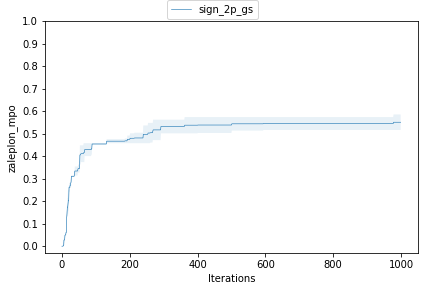

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_qmo(score, q, trajectory=False, spacing=10):
    logdir = f'runs/{task_str}'
    fig, ax = plt.subplots(1,1)

    n = 1 # number of starting molecules run 
    smi_set = [smi] # can modify if multiple molecules are run
    zooms = os.listdir(logdir) # if multiple ZO opt methods are run
    
    for zoom_i,zoom in enumerate(zooms):
        params = f'(beta={B}, Q={Q}, lr={lr})'

        res = np.zeros(shape=(k*n, T))
        for _,x0 in enumerate(smi_set):
            rundir = f'{logdir}/{zoom}/{params}/{x0}'
            ea = EventAccumulator(rundir)
            ea.Reload()

            w_times, step_nums, vals = zip(*ea.Scalars(score))
            vals = np.array(vals)
            vals = np.where(np.isfinite(vals),vals, 0)

            if not trajectory:
                best = [vals[i*T] for i in range(k)]
                for i in range(1, T):
                    for j in range(k):
                        best[j] = max(best[j], vals[j*T + i])
                        vals[j*T + i] = best[j]
                        res[j*n + _][i] = best[j]
        
        if spacing is not None:
            xs = spacing * np.arange(int(T/spacing))
            tmp = np.zeros(int(T/spacing))
            error = np.zeros(int(T/spacing))
        else:
            xs = range(T)
            tmp = np.zeros(T)
            error = np.zeros(T)
        for i in xs:
            ind = int(i/spacing) if spacing is not None else i
            tmp[ind] = np.mean(res[:, i])
            error[ind] = np.std(res[:, i])
        ax.plot(xs, tmp, label=zoom, linewidth=0.6)
        ax.fill_between(xs, tmp-error, tmp+error, alpha=0.1, linewidth=0)
    
    leg = fig.legend(loc="upper center", borderaxespad=0.05, ncol=int((len(zooms)+1) / 2))
    ax.set_xlabel('Iterations')
    ax.set_ylabel(objective)
    ax.set_xticks(np.arange(0,T+1,int(T/5)))
    ax.set_yticks(np.arange(0,1.01,0.1))
    fig.tight_layout()
    plt.show()

plot_qmo(objective, Q, trajectory=False, spacing=None)

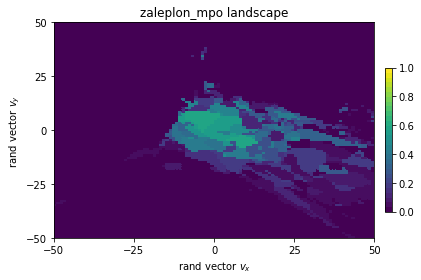

In [14]:
def func(score, smiles, embedding, X, Y, u, v, model):
    oracle = Oracle(name = score)
    smi = canonical(model.decode(embedding)[1][0]) ###
    z = embedding # model.encode(embedding)[0]
    dim = X.size()[0]
    z_tmp = torch.Tensor(dim*dim, 512) # to contain all of the peturbed molecules
    
    Z = torch.Tensor(size=(dim,dim))
    for i in range(dim):
        for j in range(dim):
            a, b = X[i][j], Y[i][j]
            z_tmp[i*dim + j] = z + a*u + b*v

    smi_lst = model.decode(z_tmp)[1]
    for i in range(dim):
        for j in range(dim):
            smi_tmp = smi_lst[i*dim+j]
            try:
                Z[i][j] = oracle(smi_tmp)
            except:
                Z[i][j] = float('nan')
    return Z

def plot_landscape(fig, ax, score, smiles, embedding, radius, step, seed=123456789, plot_type='heatmap', make_cmap=False):
    np.random.seed(seed)
    tf.set_random_seed(seed)
    torch.manual_seed(seed)

    model = CDDDModel()
    u = np.random.normal(0, 100, size=512).astype('float32')
    u = torch.from_numpy(u / np.linalg.norm(u, keepdims=True))
    v = np.random.normal(0, 100, size=512).astype('float32')
    v = torch.from_numpy(v / np.linalg.norm(v, keepdims=True))

    x = torch.linspace(-radius, radius, int(2*radius/step)+1)
    y = torch.linspace(-radius, radius, int(2*radius/step)+1)
    X, Y = torch.meshgrid(x, y)
    Z = func(score, smiles, embedding, X, Y, u, v, model)

    cmap = mpl.cm.get_cmap('viridis', 30)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cmesh = ax.pcolormesh(X, Y, Z, cmap=cmap, norm=norm)
    ax.set_xlabel('rand vector $v_{x}$')
    ax.set_ylabel('rand vector $v_{y}$')

    if make_cmap:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.9, 0.25, 0.015, 0.5])
        cbar = fig.colorbar(cmesh, cax=cbar_ax)

def plot_heatmaps(smi, radius=50, step=1):
    fig, ax = plt.subplots(1,1)
    
    res = np.load(f'/content/results/{task_str}/{zo_method}/{hyperparams_str}/{smi}.npz')
    embed = torch.tensor(res['z'][0])
    
    ax.set_xticks(np.arange(-radius, radius+1, int(radius/2)))
    ax.set_yticks(np.arange(-radius, radius+1, int(radius/2)))
    oracle = Oracle(name=objective)
    plot_landscape(fig, ax, objective, smi, embed, radius, step, plot_type='heatmap', make_cmap=True)

    ax.set_title(f'{objective} landscape')
    fig.tight_layout()
    fig.subplots_adjust(right=0.875)
    plt.show()

plot_heatmaps(smi, radius=50, step=1)